In [2]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
data_dir = "trafic_32"

transform = transforms.Compose([
    transforms.ToTensor(),
])


In [8]:
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
print(len(full_dataset.classes))

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

43


tensor([ 8,  3,  7,  9,  4, 39, 30, 31])
Input shape: torch.Size([8, 3, 32, 32])


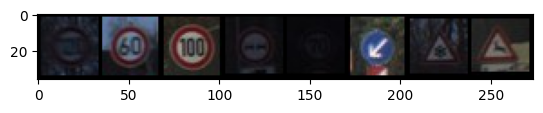

In [7]:
x, y = next(iter(train_loader))
x,y = x[:8], y[:8]
print(y)
print(f"Input shape: {x.shape}")
plt.imshow(torchvision.utils.make_grid(x).permute(1, 2, 0))

### Diffusion model

In [22]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x*(1 - amount) + noise*amount

In [36]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_emb_dim=1, class_emb_dim=1):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.class_emb_dim = class_emb_dim
        self.total_emb_dim = time_emb_dim + class_emb_dim

        self.down_layers = nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])

        self.up_layers = nn.ModuleList([
            nn.Conv2d(64 + self.total_emb_dim, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])

        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x, t, y):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        # Expand time and label embeddings
        t = t.view(t.size(0), self.time_emb_dim, 1, 1).repeat(1, 1, x.size(2), x.size(3))
        y = y.view(y.size(0), self.class_emb_dim, 1, 1).repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, t, y], dim=1)

        for i, l in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x += h.pop()
            x = self.act(l(x))

        return x

In [37]:
net = BasicUNet().to(device)
net

BasicUNet(
  (down_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (up_layers): ModuleList(
    (0): Conv2d(66, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (act): SiLU()
  (downscale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
)

In [38]:
n_epochs = 10

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)


In [39]:
losses = []

for epoch in range(n_epochs):

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x, noise_amount,y)

        loss = loss_fn(pred, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_loader):])/len(train_loader)
    print(f"Finished epoch {epoch}, Avg epoch loss: {avg_loss:.5f}")

Finished epoch 0, Avg epoch loss: 0.02144
Finished epoch 1, Avg epoch loss: 0.01596
Finished epoch 2, Avg epoch loss: 0.01454
Finished epoch 3, Avg epoch loss: 0.01374
Finished epoch 4, Avg epoch loss: 0.01357
Finished epoch 5, Avg epoch loss: 0.01325
Finished epoch 6, Avg epoch loss: 0.01259
Finished epoch 7, Avg epoch loss: 0.01284
Finished epoch 8, Avg epoch loss: 0.01271
Finished epoch 9, Avg epoch loss: 0.01243


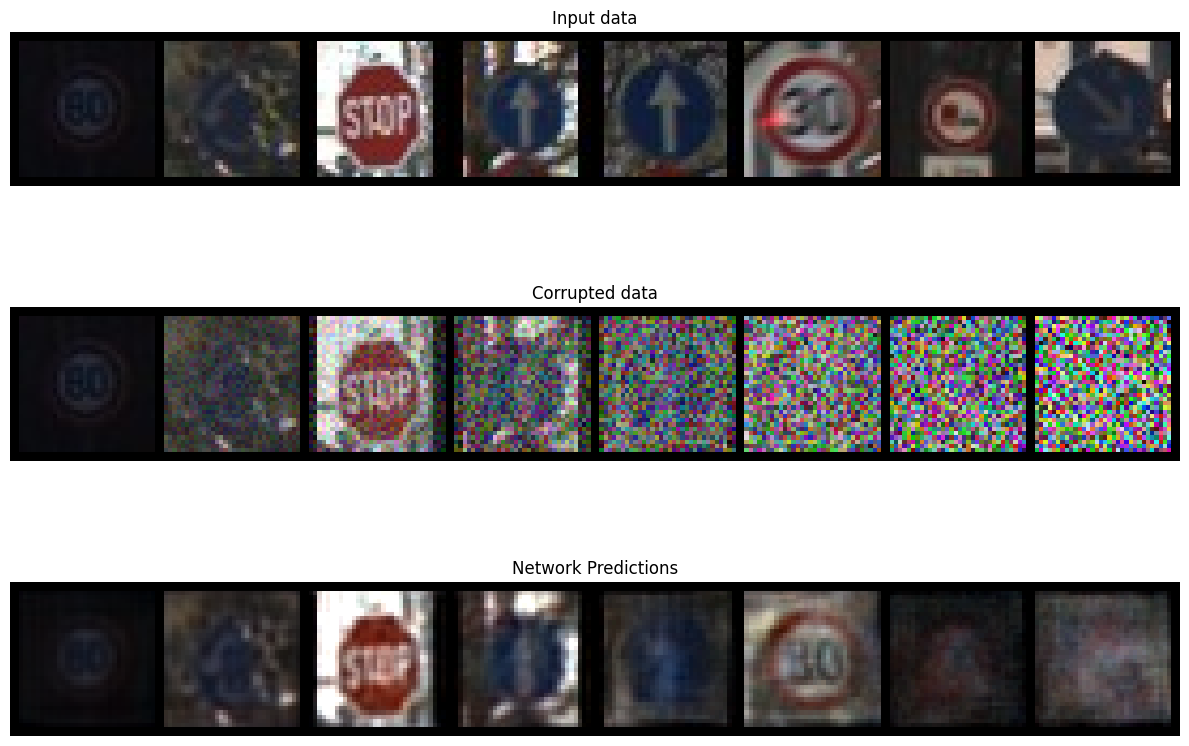

In [40]:
x, y = next(iter(val_loader))
x, y = x[:8], y[:8]

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
    preds = net(noised_x.to(device), amount.to(device), y.to(device)).detach().cpu()

# --- Step 8: Show results ---
def show_batch(title, imgs, ax):
    grid = torchvision.utils.make_grid(imgs, nrow=imgs.size(0))
    grid = grid.permute(1, 2, 0).clip(0, 1).cpu().numpy()
    ax.imshow(grid)
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(3, 1, figsize=(12, 9))

show_batch("Input data",        x,        axs[0])
show_batch("Corrupted data",    noised_x, axs[1])
show_batch("Network Predictions", preds,  axs[2])

plt.tight_layout()
plt.show()

In [ ]:
#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:

n_steps = 40
x = torch.rand(8,3, 32, 32).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    t = (torch.zeros(x.size(0)) + (n_steps - i)/n_steps).to(device)
    print(f"Timestep: {t[0].item():.2}")
    with torch.no_grad():
        pred = net(x, t) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    #---------- Uzupełnij proces generowania
    mix_factor = 1/(n_steps -i)
    x = x*(1-mix_factor) + pred*mix_factor # Mix the prediction with the current x
    #---------------------------------------
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')